In [70]:
# Only these three packages are allowed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [71]:
class FLD:
    def __init__(self):
        """
            You can add/change any variables/methods to meet your need.
        """
        self.mean_vectors = None
        self.sw = None
        self.sb = None
        self.w = None
        self.slope = None

    def fit(self, X, y):
        num_features = X.shape[1]
        unique_classes = np.unique(y)
        num_classes = len(unique_classes)

        mean_vectors = []
        for classes in unique_classes:
            mean_vectors.append(np.mean(X[y==classes], axis=0))
        mean_vectors = np.array(mean_vectors)
        
        Sw = np.zeros((num_features, num_features))
        Sb = np.zeros((num_features, num_features))
        all_mean = np.mean(X, axis=0)
        for classes, vectors in zip(unique_classes, mean_vectors):
            X_class = X[y == classes]
            Sw += np.dot((X_class - vectors).T, (X_class - vectors))
            diff = (vectors - all_mean).reshape(num_features, 1)
            Sb += len(X_class) * np.dot(diff, (diff.T))

        eigenvalues, eigenvectors = np.linalg.eig(np.dot(np.linalg.inv(Sw), (Sb)))
        eig_pairs = [(np.abs(eigenvalues[i]), eigenvectors[:,i]) for i in range(len(eigenvalues))]
        eig_pairs.sort(key=lambda x: x[0], reverse=True)
        w = eig_pairs[0][1]

        self.slope = w[1] / w[0]

        self.mean_vectors = mean_vectors
        self.sw = Sw
        self.sb = Sb
        self.w = w

    def predict_using_class_mean(self, X, y, X_test):
        num_test = X_test.shape[0]
        y_pred = np.zeros(num_test)
        for i, x_test in enumerate(X_test):
            distances = np.linalg.norm(self.mean_vectors - x_test, axis=1)
            y_pred[i] = np.argmin(distances)
        return y_pred

    def predict_using_knn(self, X, y, X_test, k=1):
        num_test = X_test.shape[0]
        y_pred = np.zeros(num_test)
        for i, x_test in enumerate(X_test):
            distances = np.linalg.norm(X - x_test, axis=1)
            sorted_index = np.argsort(distances)
            knn_index = sorted_index[:k]
            knn_labels = y[knn_index]
            unique_labels, counts = np.unique(knn_labels, return_counts=True)
            y_pred[i] = unique_labels[np.argmax(counts)]
        return y_pred

    def show_confusion_matrix(self, y, y_pred):
        unique_labels = np.unique(y)
        num_classes = len(unique_labels)
        conf_matrix = np.zeros((num_classes, num_classes))
        for i, true_label in enumerate(unique_labels):
            for j, pred_label in enumerate(unique_labels):
                conf_matrix[i, j] = np.sum((y == true_label) & (y_pred == pred_label))
        
        plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion matrix')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.xticks(y_pred)
        plt.yticks(y)
        plt.colorbar()
        thresh=conf_matrix.max()/2
        iter=np.reshape([[[i, j] for j in range(num_classes)] for i in range(num_classes)], (conf_matrix.size, 2))
        for i, j in iter:
            plt.text(j, i, format(conf_matrix[i, j]), va='center', ha='center', color="white" if conf_matrix[i, j] > thresh else "black")
        plt.show()

    def plot_projection(self, X, y):
        colors = ['r', 'b', 'g']
        plt.scatter(X[:, 0], X[:, 1], s=5, c=[colors[label] for label in y])
        
        X_lda = np.dot(X,self.w)
        X_new = [i * self.w for i in X_lda]
        X_new = np.array(X_new)
        for i in range(len(X_lda)):
            plt.scatter(X_new[i, 0], X_new[i, 1], s=5, c=colors[y[i]])
            plt.plot([X[i, 0], X_new[i, 0]], [X[i, 1], X_new[i, 1]], linewidth=0.5, c=colors[y[i]], alpha=0.2)
            
        point_min = min(X_lda) * self.w
        point_max = max(X_lda) * self.w
        x_line = np.linspace(point_min[0], point_max[0], num=100)
        y_line = np.linspace(point_min[1], point_max[1], num=100)
        plt.plot(x_line, y_line, color='black', label='projection')
        
        title = 'Projection Line: w= ' + str(self.slope) + ', b= 0'
        plt.title(title)
        plt.legend()
        plt.show()

    def accuracy_score(self, y, y_pred):
        sum_y = []
        sum_y.append(y == y_pred)
        return np.mean(sum_y)

In [3]:
class MultiClassLogisticRegression:
    
    def __init__(self):
        """
            You can add/change any variables/methods to meet your need.
        """
        self.epoch = []
        self.train_loss = []
        self.weights = None
        self.num_classes = None
        self.num_features = None

    def fit(self, X, y, batch_size=16, lr=0.001, epoch=100):
        y_one_hot = np.eye(np.max(y)+1)[y.reshape(-1)]
        self.num_classes = y_one_hot.shape[1]
        self.num_features = X.shape[1]
        
        #self.weights = np.random.randn(self.num_features, self.num_classes)
        self.weights = np.zeros((self.num_features, self.num_classes))
        
        for epoch_i in range(epoch):
            for batch in range(len(X)//batch_size):
                X_batch = X[batch * batch_size: (batch + 1) * batch_size]
                y_one_hot_batch = y_one_hot[batch * batch_size: (batch + 1) * batch_size]

                z = np.dot(X_batch, self.weights)
                probs = self.softmax(z)
                loss = self.cross_entropy(y_one_hot_batch, probs)

                error = probs - y_one_hot_batch
                grad = np.dot(X_batch.T, error)
                self.weights -= lr * (grad / batch_size)

            self.epoch.append(epoch_i)
            self.train_loss.append(loss)

    def predict(self, X):
        z = np.dot(X, self.weights)
        probs = self.softmax(z)
        return np.argmax(probs, axis=1)

    def evaluate(self, X, y):
        # Evaluate accuracy using predict method
        y_pred = self.predict(X)
        return self.accuracy_score(y, y_pred)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        result = exp_z / np.sum(exp_z, axis=1, keepdims=True)
        return result

    def cross_entropy(self, y, probs):
        return -np.sum(y * np.log(probs)) / y.shape[0]
    
    def accuracy_score(self, y, y_pred):
        # Accuracy score
        sum_y = []
        sum_y.append(y == y_pred)
        return np.mean(sum_y)

    def show_confusion_matrix(self, X, y):
        # Confusion matrix
        y_pred = self.predict(X)
        conf_matrix = np.zeros((self.num_classes, self.num_classes))
        for i in range(len(y)):
            conf_matrix[y[i], y_pred[i]] += 1
        #return conf_matrix
        plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion matrix')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.xticks(y_pred)
        plt.yticks(y)
        plt.colorbar()
        thresh=conf_matrix.max()/2
        iter=np.reshape([[[i, j] for j in range(self.num_classes)] for i in range(self.num_classes)], (conf_matrix.size, 2))
        for i, j in iter:
            plt.text(j, i, format(conf_matrix[i, j]), va='center', ha='center', color="white" if conf_matrix[i, j] > thresh else "black")

        plt.show()
    
    def plot_curve(self):
        # self.epoch and self.train_loss may be helpful here. 
        plt.plot(self.epoch, self.train_loss, label='Training CE Loss')
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('CE Loss')
        plt.legend()
        plt.show()

# Prepare data for Q1 ~ Q12

In [72]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW2_blob_train.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW2_blob_test.csv"))

In [73]:
X_train = df_train[['Feature1', 'Feature2']].to_numpy()
y_train = df_train[['Target']].to_numpy().ravel()

X_test = df_test[['Feature1', 'Feature2']].to_numpy()
y_test = df_test[['Target']].to_numpy().ravel()

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test",  X_test.shape)
print("y_test",  y_test.shape)

X_train (1000, 2)
y_train (1000,)
X_test (1000, 2)
y_test (1000,)


# MultiClass Logistic Regression

In [6]:
# For Q1
lr = 0.001
batch_size = 16
epoch = 100

logistic_reg = MultiClassLogisticRegression()
logistic_reg.fit(X_train, y_train, lr=lr, batch_size=batch_size, epoch=epoch)


y_one_hot = np.eye(np.max(y_train)+1)[y_train.reshape(-1)]
#print("y_train", y_train)
print("X.shape", X_train.shape)
print("X.shape", X_train.shape[1])

X.shape (1000, 2)
X.shape 2


In [7]:
# For Q2
print('Training acc: ', logistic_reg.evaluate(X_train, y_train))

Training acc:  0.896


In [8]:
# For Q3
print('Testing acc: ', logistic_reg.evaluate(X_test, y_test))

Testing acc:  0.885


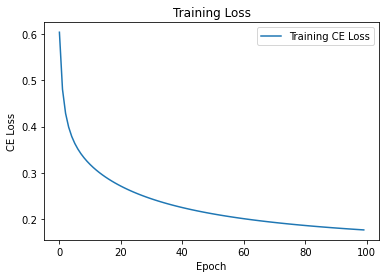

In [9]:
# For Q4
logistic_reg.plot_curve()

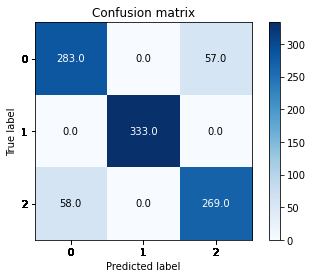

In [10]:
# For Q5
logistic_reg.show_confusion_matrix(X_test, y_test)

# Fisher's Linear Discriminant Analysis

In [74]:
fld = FLD()

fld.fit(X_train, y_train)

In [75]:
# For Q6
print("Class mean vector: ", fld.mean_vectors)

Class mean vector:  [[-4.17505764  6.35526804]
 [-9.43385176 -4.87830741]
 [-2.54454008  7.53144179]]


In [76]:
# For Q7
print("Within-class scatter matrix SW: ", fld.sw)

Within-class scatter matrix SW:  [[1052.70745046  -12.5828441 ]
 [ -12.5828441   971.29686189]]


In [77]:
# For Q8
print("Between-class scatter matrix SB: ", fld.sb)

Between-class scatter matrix SB:  [[ 8689.12907035 16344.86572983]
 [16344.86572983 31372.93949414]]


In [78]:
# For Q9
print("W: ", fld.w)

W:  [-0.44115384 -0.8974315 ]


FLD using class mean, accuracy:  0.886


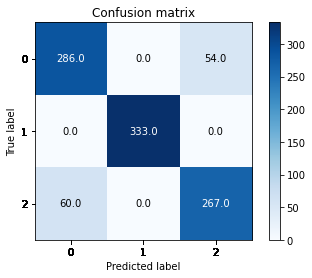

In [79]:
# For Q10
y_pred = fld.predict_using_class_mean(X_train, y_train, X_test)
print("FLD using class mean, accuracy: ", fld.accuracy_score(y_test, y_pred))

fld.show_confusion_matrix(y_test, y_pred)

In [84]:
# For Q11
y_pred_k1 = fld.predict_using_knn(X_train, y_train, X_test, k=1)
print("FLD using knn (k=1), accuracy: ", fld.accuracy_score(y_test, y_pred_k1))

y_pred_k2 = fld.predict_using_knn(X_train, y_train, X_test, k=2)
print("FLD using knn (k=2), accuracy: ", fld.accuracy_score(y_test, y_pred_k2))

y_pred_k3 = fld.predict_using_knn(X_train, y_train, X_test, k=3)
print("FLD using knn (k=3), accuracy: ", fld.accuracy_score(y_test, y_pred_k3))

y_pred_k4 = fld.predict_using_knn(X_train, y_train, X_test, k=4)
print("FLD using knn (k=4), accuracy: ", fld.accuracy_score(y_test, y_pred_k4))

y_pred_k5 = fld.predict_using_knn(X_train, y_train, X_test, k=5)
print("FLD using knn (k=5), accuracy: ", fld.accuracy_score(y_test, y_pred_k5))

y_pred_k10 = fld.predict_using_knn(X_train, y_train, X_test, k=100)
print("FLD using knn (k=10), accuracy: ", fld.accuracy_score(y_test, y_pred_k10))

FLD using knn (k=1), accuracy:  0.839
FLD using knn (k=2), accuracy:  0.846
FLD using knn (k=3), accuracy:  0.878
FLD using knn (k=4), accuracy:  0.876
FLD using knn (k=5), accuracy:  0.878
FLD using knn (k=10), accuracy:  0.887


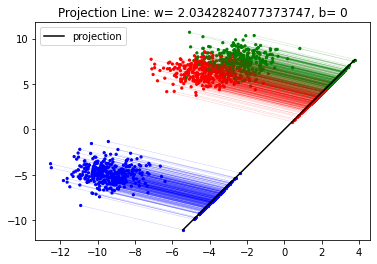

In [81]:
# For Q12, using only training data
fld.plot_projection(X_train, y_train)

# Train your own model on provided dataset.
You can only using 1) **Fisher's Linear Discriminant** or 2) **Logistic Regression** that you have implemented above.

In [19]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW2_train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW2_val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW2_test.csv"))

In [20]:
df_train.head()

,Feature1,Feature2,Feature3,Feature4,Target
0,0.00668,0.00192,0.682,0.996,2.0
1,0.00680,0.00106,0.503,0.996,1.0
2,0.00742,0.00106,0.482,0.991,1.0
3,0.00685,0.00178,0.650,0.998,2.0
4,0.00680,0.00163,0.623,0.996,2.0


In [21]:
df_test.head()

,Feature1,Feature2,Feature3,Feature4,Target
0,0.00699,0.000877,0.451,0.994,NaN
1,0.00736,0.001370,0.549,0.998,NaN
2,0.00687,0.001420,0.580,0.992,NaN
3,0.00752,0.002520,0.737,0.996,NaN
4,0.00685,0.000910,0.464,0.992,NaN


In [22]:
# Data processing

# Refer to section "Prepare data for Q1 ~ Q12"

In [23]:
# Train your model here

# your_model = ...

In [24]:
test_pred = your_model.predict(x_test)
print("test_pred shape: ", test_pred.shape)

NameError: name 'your_model' is not defined

# Output the csv file

In [ ]:
# For Q13
df_test = pd.DataFrame(pd.read_csv("./PR_HW2_test.csv"))
df_test["Target"] = test_pred
df_test.to_csv("sample_output.csv")